In [1]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.cluster import SpectralClustering
import umap
from rdkit import Chem
from rdkit.Chem import AllChem
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

df = pd.read_csv('Lipophilicity.csv')
print(df.info())
df.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4200 entries, 0 to 4199
Data columns (total 3 columns):
CMPD_CHEMBLID    4200 non-null object
exp              4200 non-null float64
smiles           4200 non-null object
dtypes: float64(1), object(2)
memory usage: 98.5+ KB
None


,CMPD_CHEMBLID,exp,smiles
0,CHEMBL596271,3.54,Cn1c(CN2CCN(CC2)c3ccc(Cl)cc3)nc4ccccc14
1,CHEMBL1951080,-1.18,COc1cc(OC)c(cc1NC(=O)CSCC(=O)O)S(=O)(=O)N2C(C)...
2,CHEMBL1771,3.69,COC(=O)[C@@H](N1CCc2sccc2C1)c3ccccc3Cl
3,CHEMBL234951,3.37,OC[C@H](O)CN1C(=O)C(Cc2ccccc12)NC(=O)c3cc4cc(C...
4,CHEMBL565079,3.10,Cc1cccc(C[C@H](NC(=O)c2cc(nn2C)C(C)(C)C)C(=O)N...


In [2]:
#無効なSMILESの確認
smiles = []
for s in df.smiles:
    try:
        cs = Chem.CanonSmiles(s)
        smiles.append(cs)
    except:
        print('invalid smiles: ', s)

In [3]:
# Morganフィンガープリントの取得
mols = [Chem.MolFromSmiles(x) for x in df.smiles]
morgan_fps = [AllChem.GetMorganFingerprintAsBitVect(x, 2, 1024) for x in mols]
rdkit_fps = [Chem.RDKFingerprint(x, fpSize=1024) for x in mols]

# fingerprintをDFに格納
df_morgan_fps = pd.DataFrame(np.array(morgan_fps))
df_rdkit_fps = pd.DataFrame(np.array(rdkit_fps))

print(df_morgan_fps.shape)

(4200, 1024)


In [4]:
kmeans = KMeans(n_clusters=50, n_jobs=-1)
kmeans.fit(df_morgan_fps)

pca = PCA(n_components = 2)
decomp = pca.fit_transform(df_morgan_fps)

x = decomp[:,0]
y = decomp[:,1]

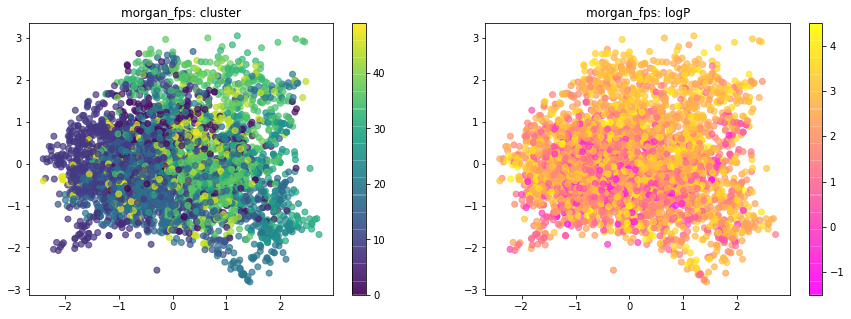

In [5]:
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
plt.scatter(x, y, c= kmeans.labels_, alpha=0.7)
plt.title("morgan_fps: cluster")
plt.colorbar()

plt.subplot(1,2,2)
plt.scatter(x, y, c= df.exp, alpha=0.7, cmap='spring')
plt.title("morgan_fps: logP")
plt.colorbar()

In [6]:
kmeans = KMeans(n_clusters=50, n_jobs=-1)
kmeans.fit(df_rdkit_fps)

pca = PCA(n_components = 2)
decomp = pca.fit_transform(df_rdkit_fps)

x = decomp[:,0]
y = decomp[:,1]

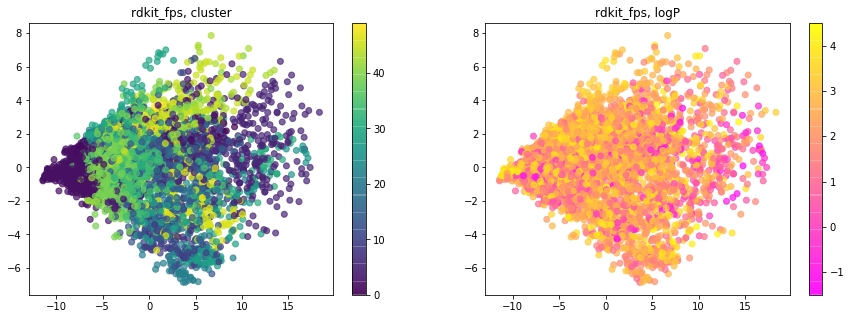

In [7]:
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
plt.scatter(x, y, c= kmeans.labels_, alpha=0.7)
plt.title("rdkit_fps, cluster")
plt.colorbar()

plt.subplot(1,2,2)
plt.scatter(x, y, c= df.exp, alpha=0.7, cmap='spring')
plt.title("rdkit_fps, logP")
plt.colorbar()

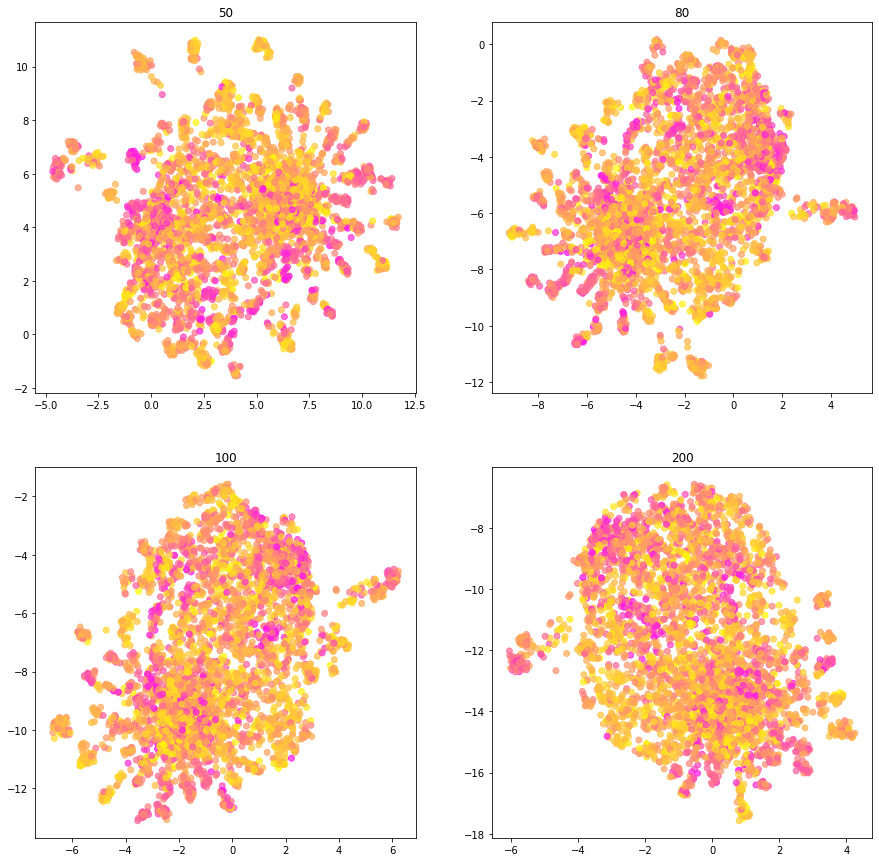

In [8]:
fig = plt.figure(figsize=(15,15))
for i,c in enumerate([50,80,100,200]):
    embedding = umap.UMAP(n_neighbors = c,
                          n_components = 2,
                          min_dist=0.5).fit_transform(df_rdkit_fps)
    
    ax = fig.add_subplot(2,2,i+1)
    ax.scatter(embedding[:,0],embedding[:,1], alpha=0.7, c= df.exp, cmap='spring')
    ax.set_title(c)

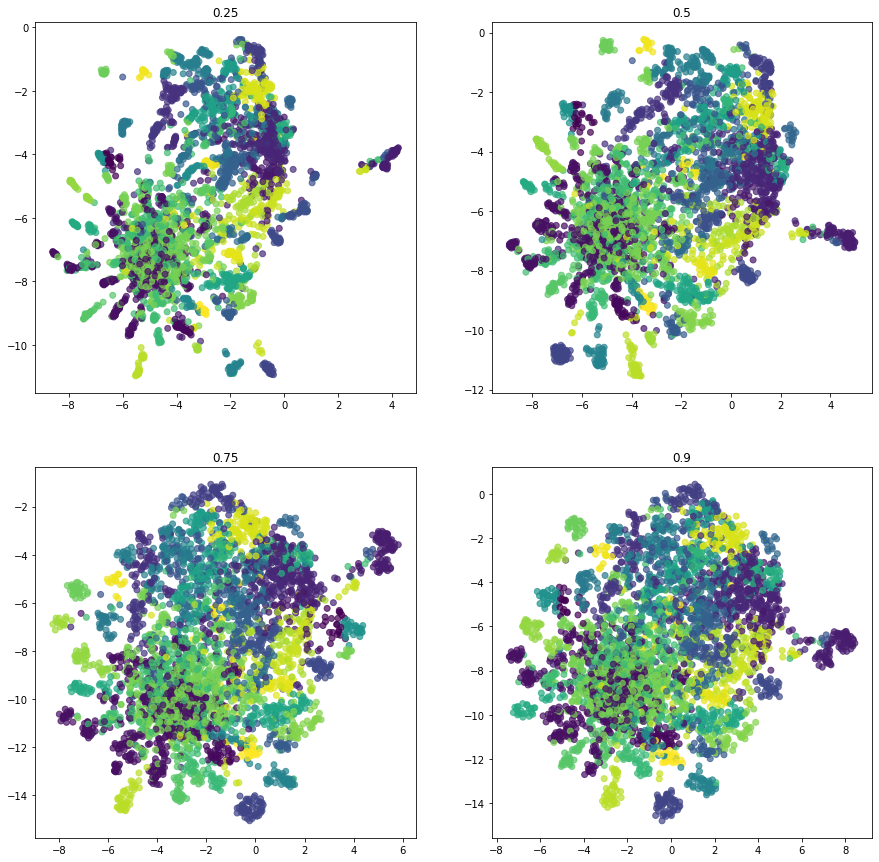

In [9]:
fig = plt.figure(figsize=(15,15))
for i,c in enumerate([0.25, 0.5, 0.75, 0.9]):
    embedding = umap.UMAP(n_neighbors = 80,
                          n_components = 2,
                          min_dist=c).fit_transform(df_rdkit_fps)
    
    ax = fig.add_subplot(2,2,i+1)
    ax.scatter(embedding[:,0],embedding[:,1], alpha=0.7, c= kmeans.labels_)
    ax.set_title(c)

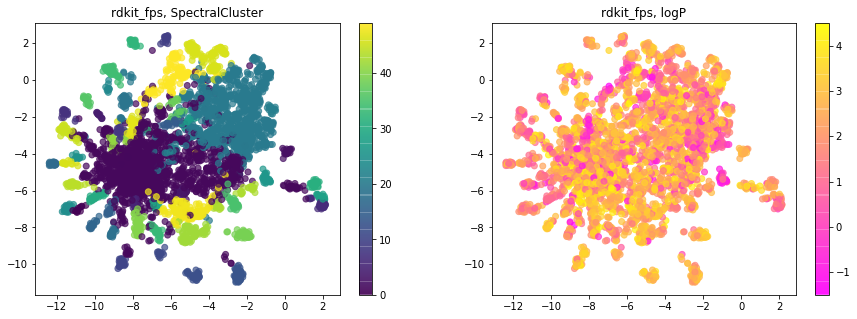

In [10]:
from sklearn.cluster import SpectralClustering
sc = SpectralClustering(n_clusters=50, affinity= 'nearest_neighbors', n_jobs =-1)
sc.fit(df_rdkit_fps)

embedding = umap.UMAP(n_neighbors = 50,
                      n_components = 2,
                      min_dist=0.5).fit_transform(df_rdkit_fps)

x = embedding[:,0]
y = embedding[:,1]

fig = plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.scatter(x, y, c= sc.labels_, alpha=0.7)
plt.title("rdkit_fps, SpectralCluster")
plt.colorbar()

plt.subplot(1,2,2)
plt.scatter(x, y, c= df.exp, alpha=0.7, cmap='spring')
plt.title("rdkit_fps, logP")
plt.colorbar()